# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

### **Note: Please use GPU runtime on Google Colab to execute the code faster.**

## Importing necessary libraries

In [ ]:
#!pip install numpy==1.25.2 pandas==2.0.3 seaborn==0.13.1 tensorflow==2.15.0 scikit-learn==1.2.2 matplotlib==3.7.1

**Note**: *After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.*

In [12]:
#Importing the required libraries

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Imporing the libraries as required. Note that we are using tensorflow.keras here.
import tensorflow as tf
# Keras Sequential Model
from keras.models import Sequential
# Keras Layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
# Keras Optimizers
from keras.optimizers import Adam,SGD
# Keras ImageDataGenerator for data augmentation
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# OpenCV for image processing
import cv2
# Display images using OpenCV
from google.colab.patches import cv2_imshow

## Loading the dataset

In [15]:
images_data = np.load('/content/images.npy')
labels_data = pd.read_csv('/content/Labels.csv')

ValueError: cannot reshape array of size 28311424 into shape (4750,128,128,3)

## Data Overview

#### Summary

Shape & details
- 4750 images of 128x128 size and with 3 channels
- 4750 labels with 12 unique labels
- No null label entries
- Top classified plant is `Loose Silky-bent` and least is `Common wheat`, `Maize`

Color channels
- Color channel observed is BGR
- imshow uses RGB convention and when BGR pixels are passed in it shows a blueish image which is not seems to be the correct one
- When inverted the last channel, it seems to be right one


### Understand the shape of the dataset

In [4]:
print("Images data - shape : ", images_data.shape)
# (num_samples, height, width, channels)

print("Images data - dtype : ", images_data.dtype)

NameError: name 'images_data' is not defined

In [4]:
print("Labels data - shape : ", labels_data.shape)

labels_data.info()

Labels data - shape :  (4750, 1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4750 non-null   object
dtypes: object(1)
memory usage: 37.2+ KB


In [5]:
labels_data.describe()

,Label
count,4750
unique,12
top,Loose Silky-bent
freq,654


In [6]:
labels_data.value_counts()

,count
Label,
Loose Silky-bent,654
Common Chickweed,611
Scentless Mayweed,516
Small-flowered Cranesbill,496
Fat Hen,475
Charlock,390
Sugar beet,385
Cleavers,287
Black-grass,263


### Check Color Channel (BGR to RGB if needed)

In [5]:
# Check whether original image is BGR or RGB by visually inspecting
plt.imshow(images_data[2456]) # This uses RGB convention to plot an image
plt.title("Original Image")
plt.show()

# Convert the image to RGB
image_rgb = images_data[2456][..., ::-1]

# Display the converted image
plt.imshow(image_rgb)
plt.title("After BGR to RGB Conversion")
plt.show()

NameError: name 'images_data' is not defined

## Exploratory Data Analysis

#### Visualize Labeled Images

How are these different category plant images different from each other?
- All images looks blue, so we need to convert to RGB
- Several images have barcode in the background might interfere with accuracy
- Several images are blurry even in 128 size



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function that plots images and labels
# It gathers unique categories and pick random images for each category and plots in 3x4 grid
def plot_images(images, labels):
    categories = np.unique(labels)
    category_to_image = {category: images[np.random.choice(np.where(labels == category)[0])] for category in categories}

    fig = plt.figure(figsize=(10, 8))
    rows, cols = 3, 4

    for i, category in enumerate(category_to_image):
        if i >= rows * cols:
            break
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.imshow(category_to_image[category])
        ax.set_title(f'{category}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

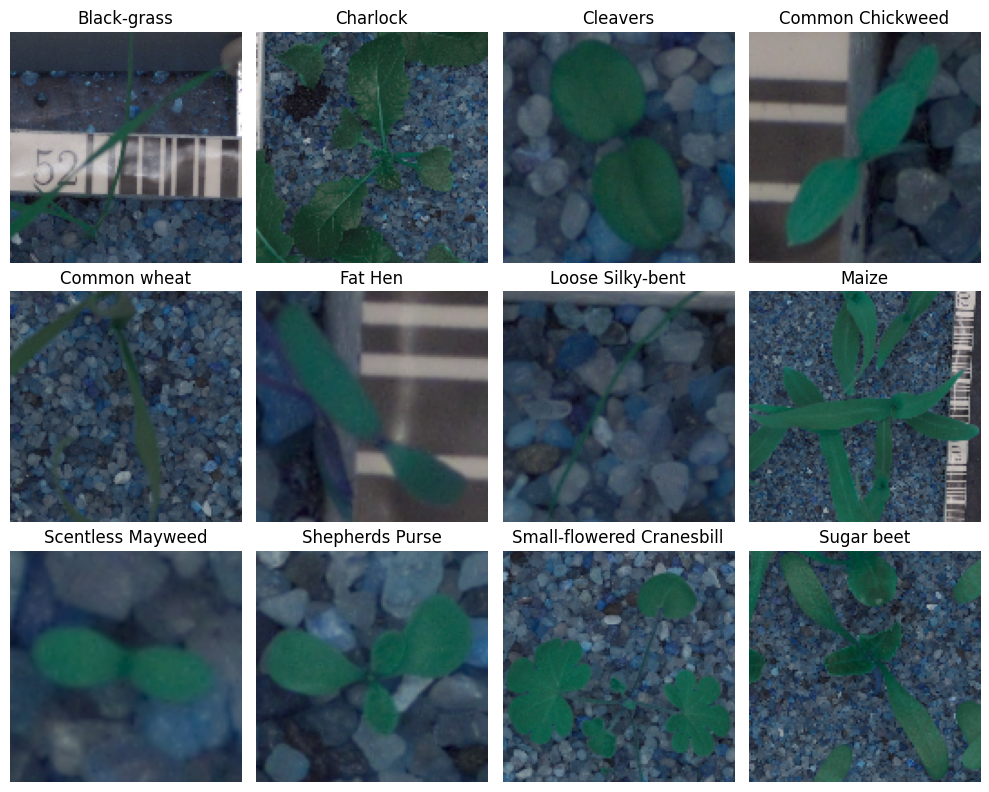

In [ ]:
plot_images(images_data,labels_data)

### Label Imbalance

Is the dataset provided an imbalance? (Check with using bar plots)

- Labeled data is slighly imbalanced
- Majority of the classified images are of 2 categories which are around 30% of labeled data (1300 datapoints between top 2)
- Few classifications have less images

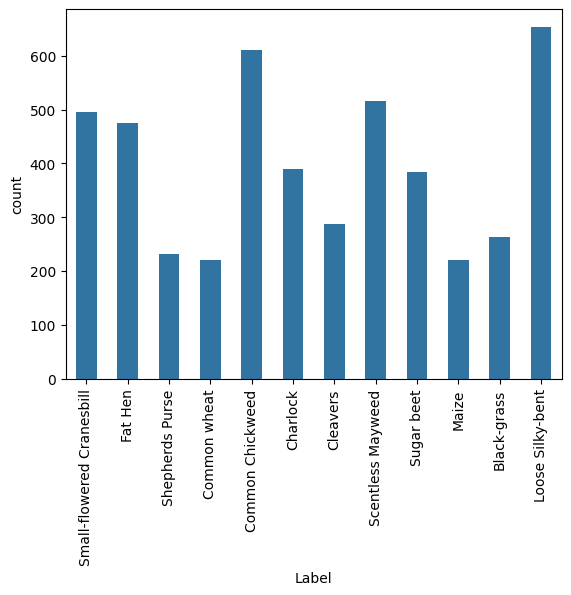

In [ ]:
# Plot labels and count of each
sns.countplot(x='Label', data=labels_data, width=0.5)
plt.xticks(rotation=90)
plt.show()

## Data Pre-Processing

#### Summary

- Images noticeably are in BGR channel, so converted to RGB channel. Visualized and confirmed random images after conversion appearing properly.
- Resized the images from bigger 128x128 to 64x64 and visualized for any blurriness. No noticeable distortion of images.

### Convert the BGR images to RGB images.

In [10]:
# Convert BGR to RGB by reversing the last dimension
images_data_rgb = images_data[..., ::-1]

NameError: name 'images_data' is not defined

In [7]:
plot_images(images_data_rgb, labels_data)

NameError: name 'plot_images' is not defined

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

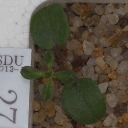

In [ ]:
# Before resizing of the image, pick random image to check
cv2_imshow(images_data_rgb[2456])

In [9]:
# Use cv2 to resize image
images_data_resized=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images_data_rgb)):
  images_data_resized.append(cv2.resize(images_data_rgb[i], dimensions, interpolation=cv2.INTER_LINEAR))


# Check whether resized image is super blurry
plt.imshow(images_data_resized[2456])
plt.title("Resized Image")
plt.show()

NameError: name 'images_data_rgb' is not defined

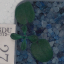

In [9]:
# After resizing of the image, pick random image to check
cv2_imshow(images_data_resized[2456])

## Data Preparation for Modeling

### Split the dataset
- Using 80% of data for train and 10% each for val and test

In [10]:
# Split the resized images dataset and labels data together into train, val and test dataset
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_data_resized), labels_data , test_size=0.1, random_state=20,stratify=labels_data)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=20,stratify=y_temp)

### Encode the target labels
- Use LabelBinarizer to encode each partitioned labels data as categorical
- One difference observed LabelEncoder does not create dummy variable for each category in your X whereas LabelBinarizer does that

In [11]:
# Encode the categorical label data
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

### Data Normalization

- Normalize the data to be between 0 and 1
- Makes its easier for cnn to learn than range of values between 0 to 255

In [12]:
# Normalize pixel values to [0, 1]
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## Basic CNN Model

#### Summary
- Basic model with conv2d layers, max pooling layers, flatten it and then dense layers.
- Dropout rate of 0.3 is also added and Adam optimizer is used with softmax 12 neuron output layer.

- Test data accuracy is around 57%.
- Heat map suggests constant mis prediction between 0 and 6th types, 4,5 and 6th types as well as bunch of other types are mis predicted.

- Overall its a overfit model considering Model Accuracy plot, as both train and validation didnt converge.

### Model Building

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
import random
np.random.seed(24)
random.seed(24)
tf.random.set_seed(24)

In [ ]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))

# Since we have 12 unique labels, we add 12 neurons and softmax for multiclass output layer
model.add(Dense(12, activation='softmax'))

# Using Adam Optimizer
opt=Adam()

# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 16)                1

In [ ]:
# Train & validate the model
history_1 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 50s - loss: 2.4261 - accuracy: 0.1541 - val_loss: 2.3386 - val_accuracy: 0.2640 - 50s/epoch - 411ms/step
Epoch 2/30
121/121 - 40s - loss: 2.2627 - accuracy: 0.2623 - val_loss: 2.0869 - val_accuracy: 0.3902 - 40s/epoch - 330ms/step
Epoch 3/30
121/121 - 40s - loss: 2.0781 - accuracy: 0.2976 - val_loss: 1.9474 - val_accuracy: 0.3995 - 40s/epoch - 330ms/step
Epoch 4/30
121/121 - 40s - loss: 1.9628 - accuracy: 0.3125 - val_loss: 1.8646 - val_accuracy: 0.3762 - 40s/epoch - 330ms/step
Epoch 5/30
121/121 - 38s - loss: 1.8891 - accuracy: 0.3312 - val_loss: 1.7179 - val_accuracy: 0.4019 - 38s/epoch - 318ms/step
Epoch 6/30
121/121 - 40s - loss: 1.8128 - accuracy: 0.3444 - val_loss: 1.6395 - val_accuracy: 0.4603 - 40s/epoch - 328ms/step
Epoch 7/30
121/121 - 40s - loss: 1.7745 - accuracy: 0.3514 - val_loss: 1.6190 - val_accuracy: 0.4065 - 40s/epoch - 327ms/step
Epoch 8/30
121/121 - 39s - loss: 1.7349 - accuracy: 0.3590 - val_loss: 1.5928 - val_accuracy: 0.4346 - 39s/epoch - 325

### Model Evaluation

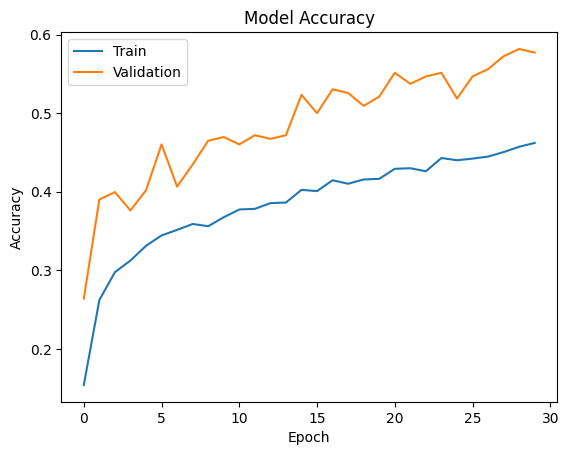

In [ ]:
# Plot training and validation accuracy of each epoch
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Print the accuracy of test data against model
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - loss: 1.3434 - accuracy: 0.5747 - 936ms/epoch - 62ms/step


In [ ]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

15/15 [==============================] - 1s 65ms/step


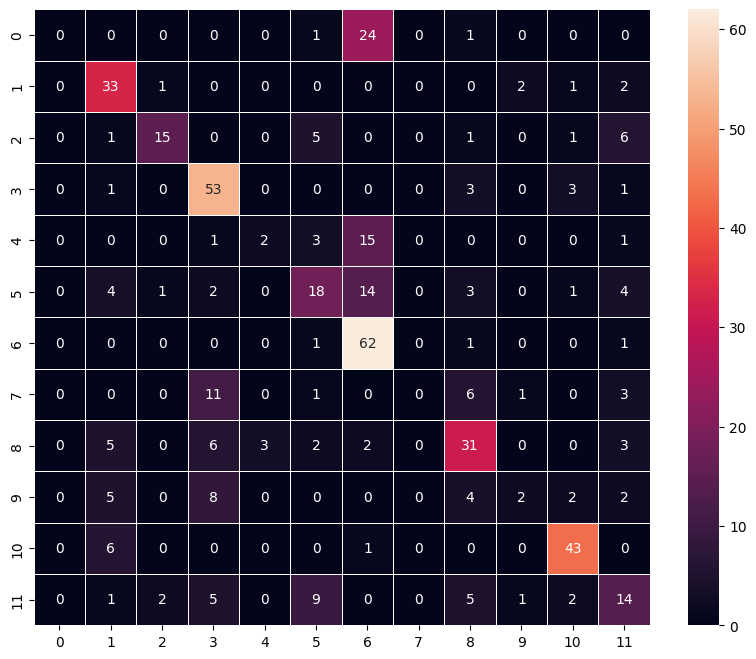

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

## CNN Model with AugmentedData

#### Summary

- Same structure as basic model.
- Only difference is data used for training is augmented data.
- Augmentation is done using `ImageDataGenerator` pipeline, with just rotation rage of 20 specified.

- Test data accuracy has improved around 67%.

- Epoch 25 the accuracy started slightly decreasing than epoch 24, so this probably is the max we can get from this model. Model converged around epoch 24.
- Heatmap suggests mis prediction across few types, like 0 and 6, but significantly better than basic model.

- Overall its a better model than base model as overfitting has reduced, but still there are drop in accuracies during epochs.



### Data Augmentation

In [13]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(24)
random.seed(24)
tf.random.set_seed(24)

In [14]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

### Model Building

In [15]:
# Intializing a sequential model
model_aug = Sequential()

model_aug.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))
model_aug.add(MaxPooling2D((2, 2), padding = 'same'))
model_aug.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_aug.add(MaxPooling2D((2, 2), padding = 'same'))
model_aug.add(BatchNormalization())
model_aug.add(Flatten())
model_aug.add(Dense(16, activation='relu'))
model_aug.add(Dropout(0.3))
model_aug.add(Dense(12, activation='softmax'))
opt=Adam()

# Compile model
model_aug.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model_aug.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 16, 16, 32)        128       
 Normalization)                                                  
                                                        

In [16]:
# Epochs
epochs = 25
# Batch size
batch_size = 64
# Train and validate model with augmented data pipeline
history_2 = model_aug.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=24,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/25
60/60 [==============================] - 55s 865ms/step - loss: 2.4344 - accuracy: 0.1409 - val_loss: 5.6063 - val_accuracy: 0.0467
Epoch 2/25
60/60 [==============================] - 64s 1s/step - loss: 2.3569 - accuracy: 0.2091 - val_loss: 32.3705 - val_accuracy: 0.1285
Epoch 3/25
60/60 [==============================] - 45s 742ms/step - loss: 2.1901 - accuracy: 0.2662 - val_loss: 64.3096 - val_accuracy: 0.1285
Epoch 4/25
60/60 [==============================] - 45s 755ms/step - loss: 2.0320 - accuracy: 0.3024 - val_loss: 132.4710 - val_accuracy: 0.1285
Epoch 5/25
60/60 [==============================] - 47s 780ms/step - loss: 1.9281 - accuracy: 0.3288 - val_loss: 273.0729 - val_accuracy: 0.0888
Epoch 6/25
60/60 [==============================] - 46s 762ms/step - loss: 1.8824 - accuracy: 0.3385 - val_loss: 371.4064 - val_accuracy: 0.1215
Epoch 7/25
60/60 [==============================] - 46s 763ms/step - loss: 1.8215 - accuracy: 0.3550 - val_loss: 529.9645 - val_accuracy:

### Model Evaluation

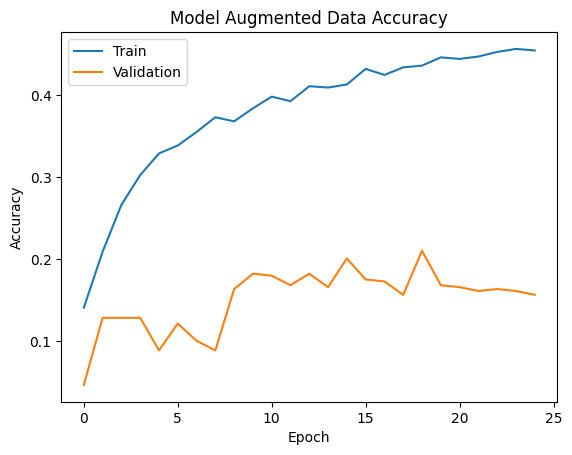

In [17]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Augmented Data Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Print the accuracy of test data against model
accuracy = model_aug.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - loss: 1.0673 - accuracy: 0.6716 - 886ms/epoch - 59ms/step


In [ ]:
# Here we would get the output as probablities for each category
y_pred = model_aug.predict(X_test_normalized)

15/15 [==============================] - 1s 71ms/step


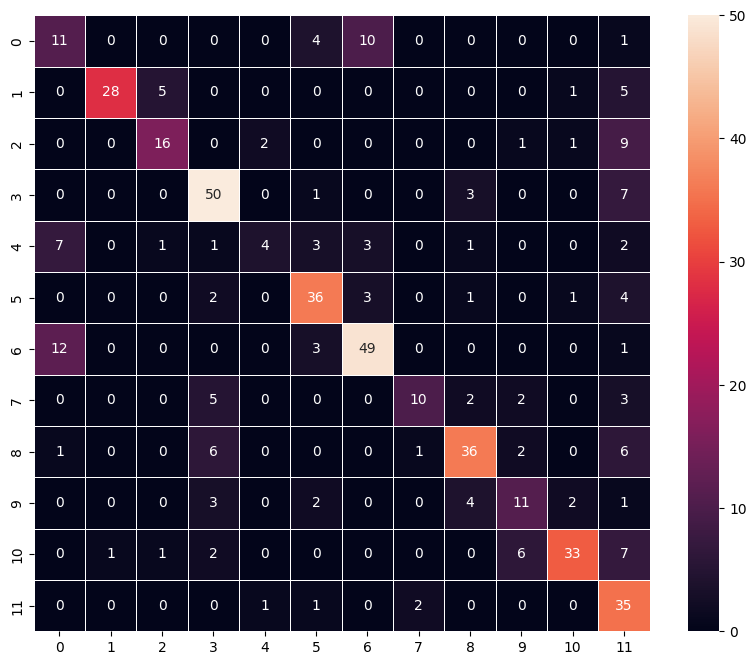

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

## CNN Model Utilizing TransferLearning


#### Summary

- Same as basic model + augmented data.

- Only difference is its prefixed with VGG16 model as base layers.

- All layers of VGG16 are marked as non-trainable and only weights are used in the training process.

- Test data accuracy is around 57%

- Epoch 25 the accuracy sill increasing than epoch 24, so this probably can be run with more epochs and we might get better accuracy as the epoch increases. (Taking more time to run so ended with 25 epochs)

- Overall this model even though its less accurcy than previous model, the accuracy chart is much better fit between train and validation data. Also heatmap suggests much cleaner predictions.

### VGG16 Model Transfer

In [ ]:
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

# Download the VGG16 model without top 3 fully connected layers
vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
vgg_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [ ]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

### Model Building With VGG16

In [ ]:
new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
new_model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
new_model.add(Flatten())

# Adding a dense output layer
new_model.add(Dense(32, activation='relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(16, activation='relu'))
new_model.add(Dense(12, activation='softmax'))
opt=Adam()
# Compile model
new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 32)                65568     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 12)                204       
                                                                 
Total params: 14780988 (56.38 MB)
Trainable params: 66

In [ ]:
# Epochs
epochs = 25
# Batch size
batch_size = 64

# Train & validate the model
history_vgg16 = new_model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/25
60/60 [==============================] - 269s 4s/step - loss: 2.3865 - accuracy: 0.1618 - val_loss: 2.2762 - val_accuracy: 0.2243
Epoch 2/25
60/60 [==============================] - 243s 4s/step - loss: 2.2147 - accuracy: 0.2591 - val_loss: 2.1057 - val_accuracy: 0.3014
Epoch 3/25
60/60 [==============================] - 258s 4s/step - loss: 2.0275 - accuracy: 0.3283 - val_loss: 1.9416 - val_accuracy: 0.3738
Epoch 4/25
60/60 [==============================] - 239s 4s/step - loss: 1.9171 - accuracy: 0.3484 - val_loss: 1.8253 - val_accuracy: 0.3832
Epoch 5/25
60/60 [==============================] - 239s 4s/step - loss: 1.8104 - accuracy: 0.3849 - val_loss: 1.7389 - val_accuracy: 0.4159
Epoch 6/25
60/60 [==============================] - 241s 4s/step - loss: 1.7196 - accuracy: 0.4087 - val_loss: 1.6657 - val_accuracy: 0.4603
Epoch 7/25
60/60 [==============================] - 240s 4s/step - loss: 1.6646 - accuracy: 0.4198 - val_loss: 1.6438 - val_accuracy: 0.4463
Epoch 8/25
60

### Model Evaluation

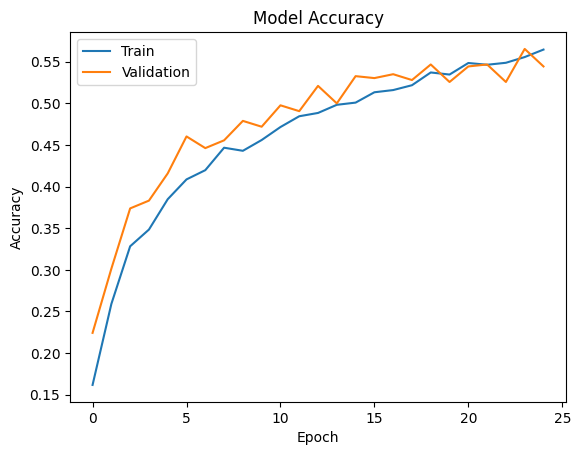

In [ ]:
# Plot training and validation accuracy of each epoch
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Print the accuracy of test data against model
accuracy = new_model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 25s - loss: 1.2632 - accuracy: 0.5726 - 25s/epoch - 2s/step


In [ ]:
# Here we would get the output as probablities for each category
y_pred=new_model.predict(X_test_normalized)

15/15 [==============================] - 25s 2s/step


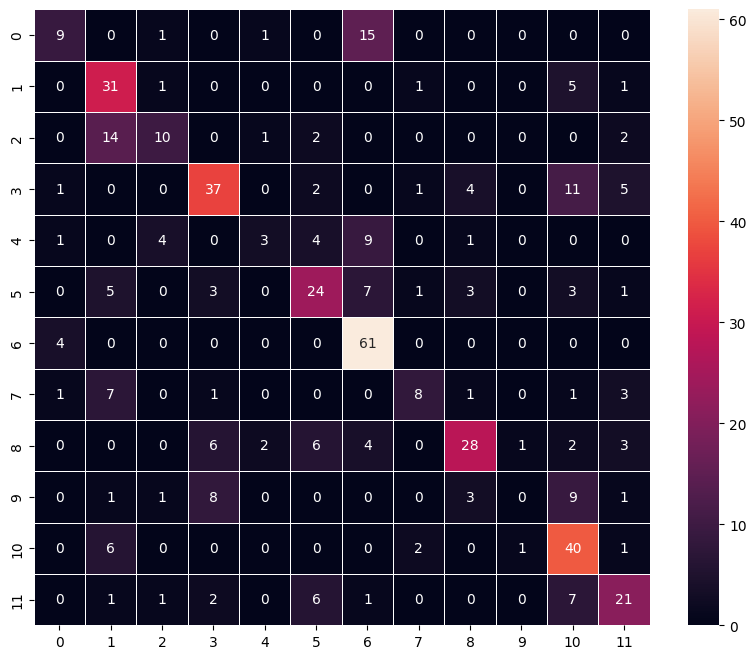

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

## Final Model

- Final model selected is the `CNN Model Utilizing Transfer Learning` of VGG16 with Augmented data.

- Reasons
  - Tight fit between train and validation accuracy during epochs
  - Model hasnt converged yet with 25 epochs, so increasing epochs would result in better accuracy
  - Total trainable params are comparatively lower as we are utilizing transfer learning
  - Using original images and more data augmentation parameters definitely would increase accuracy with this model
  - Overall 57% accuracy on test data and potential to increase with more epochs

### Visualizing the prediction

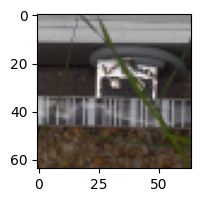

1/1 [==============================] - 0s 111ms/step
Predicted Label ['Loose Silky-bent']
True Label Black-grass


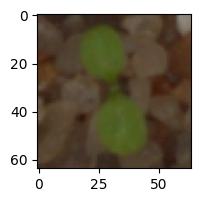

1/1 [==============================] - 0s 99ms/step
Predicted Label ['Common Chickweed']
True Label Shepherds Purse


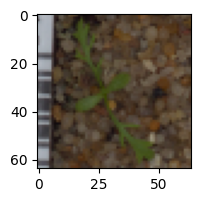

1/1 [==============================] - 0s 88ms/step
Predicted Label ['Scentless Mayweed']
True Label Scentless Mayweed


In [ ]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

### Model Accuracy Comparison

In [ ]:
# Plot all the epochs, params & accuracies across all 3 models
pd.DataFrame({'Models':['Basic CNN Model','CNN Model with AugmentedData','CNN Model Utilizing TransferLearning'],
              'Epochs':[30,25,25],
              'Total Trainable Params':[151548, 151612, 66300],
              'Train Accuracy':['46%','70%','56%'],
              'Validation Accuracy':['57%','70%','54%'],
              'Test Accuracy':['57%','67%','57%'],})

,Models,Epochs,Total Trainable Params,Train Accuracy,Validation Accuracy,Test Accuracy
0,Basic CNN Model,30,151548,46%,57%,57%
1,CNN Model with AugmentedData,25,151612,70%,70%,67%
2,CNN Model Utilizing TransferLearning,25,66300,56%,54%,57%


## Actionable Insights and Business Recommendations

**Actionable Insights**

- More varieties of seedling images with labels would help in prediction accuracy and more generalized usage of this model.

- Different stages of plants with labels should also be used so that identification can be better.

- Further augmentation on data can yield better accuracy. Also leveraging some trainable layers from VGG16 would be useful.

**Business Recommendations**

- Cameras fitted with CNN inferencing processed on edge (without internet) would help in wider adoption in agriculture fields.

- Edge devices can also be utilized for detection of weeds vs proper plant seeds in huge agricultural plots where manual identification is impossible during seedling stage.

- Proper classification can futher extended to identifying disease in plants on periodic basis and notifying with fix.

- Cameras on nurseries can help in identifying the growth of correct seeds to seedling. Identification of plants and notifying early stage would help reseed the correct plants. Saves significant amount time.


_____